# OCR Classifier

In [1]:
# loading libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import json

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, normalized_mutual_info_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Loading data into Colab

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving receipt_data.csv to receipt_data (1).csv
User uploaded file "receipt_data.csv" with length 15907937 bytes


In [0]:
# define dataset options to display entire text row
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('receipt_data.csv')

# Exploratory Analysis

In [3]:
# first glance at the dataset
df.head()

,comments,currency,lastUpdated,purchaseTime,status,uploadedTime,totalConfidence,lastOpenAt,lastVerifiedAt,taxTotal,total,deletedAt,retailerName,retailerCountry,retailerVatNumber,rawData,receiptImage
0,NaN,GBP,2019-06-15 17:00:57,2019-06-14 18:20:00,REVIEWED,2019-06-14 22:11:40,0.70,NaN,2019-06-15 17:00:57,NaN,NaN,NaN,Selfridges,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Selfridges"",""validatedEstablishment"":false,""date"":""2019-06-14 18:20:00"",""total"":30.000,""url"":""www.selfridges.com"",""phoneNumber"":""8569 4004156"",""paymentMethod"":""VISA"",""address"":""400 Oxford Street London W1A 1AB"",""validatedTotal"":false,""subTotal"":30.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.99,""totalConfidence"":0.7,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""FULTON BROLLYMA41568569 400415685692"",""unit"":"""",""price"":0.000,""descClean"":""You 193 were served by : Ines FULTON BROLLYMA 400415685692"",""lineTotal"":18.000,""productCode"":""41568569""},{""qty"":0,""desc"":""JJ DOT HYDR - TRA 82401412"",""unit"":"""",""price"":0.000,""descClean"":""JJ DOT HYDR - TRA"",""lineTotal"":12.000,""productCode"":""82401412""}],""summaryItems"":[{""qty"":2,""desc"":""Total 2 Items"",""unit"":"""",""price"":0.000,""descClean"":""Total Items"",""lineTotal"":30.000,""productCode"":""""},{""qty"":0,""desc"":""Visa"",""unit"":"""",""price"":0.000,""descClean"":""Visa"",""lineTotal"":30.000,""productCode"":""""},{""qty"":14,""desc"":""009999 Date 14 / 06 / 19"",""unit"":"""",""price"":0.000,""descClean"":""Date / 06 / 19"",""lineTotal"":18.200,""productCode"":""009999""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/5955cc32-894b-4dbd-8c1f-f54fbd95d8e8
1,NaN,GBP,2019-06-19 20:47:21,2019-06-19 13:24:00,DELETED,2019-06-19 20:01:34,0.00,NaN,2019-06-19 20:47:21,NaN,NaN,2019-06-22 21:38:31,Harrods,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_code"":3,""token"":null,""success"":true,""code"":202,""duplicate"":false,""duplicateToken"":null,""result"":{""establishment"":""Harrods"",""validatedEstablishment"":false,""date"":""2019-06-19 13:24:00"",""total"":86.000,""url"":""harrods.com"",""phoneNumber"":""020 7730 1234"",""paymentMethod"":"""",""address"":""LONDON S1 ot Road"",""validatedTotal"":false,""subTotal"":86.000,""validatedSubTotal"":true,""cash"":""0.000"",""change"":""0.000"",""tax"":0.000,""discount"":0.000,""subTotalConfidence"":0.6,""totalConfidence"":0.0,""cashConfidence"":0.0,""changeConfidence"":0.0,""roundingConfidence"":0.0,""otherData"":[],""lineItems"":[{""qty"":0,""desc"":""Rewards 0005708615 Saving FRAGRANCE"",""unit"":"""",""price"":0.000,""descClean"":""Rewards Saving FRAGRANCE f8.60"",""lineTotal"":86.000,""productCode"":""0005708615""}],""summaryItems"":[{""qty"":0,""desc"":""Sub Total"",""unit"":"""",""price"":0.000,""descClean"":""Sub Total"",""lineTotal"":86.000,""productCode"":""""},{""qty"":1,""desc"":""TOTAL ( 1 item )"",""unit"":"""",""price"":0.000,""descClean"":""TOTAL ( item )"",""lineTotal"":77.400,""productCode"":""""},{""qty"":0,""desc"":""Chinese Mobile Tendered"",""unit"":"""",""price"":0.000,""descClean"":""Chinese Mobile Tendered"",""lineTotal"":77.400,""productCode"":""""},{""qty"":0,""desc"":""Rewards Points balance"",""unit"":"""",""price"":0.000,""descClean"":""Rewards Points balance"",""lineTotal"":194.800,""productCode"":""""}]}}",https://s3-eu-west-1.amazonaws.com/wevat-receipts/c714784d-6c12-4b39-b9c4-911cc6eaaf93
2,NaN,GBP,2019-06-18 18:02:50,2019-06-18 18:24:00,REVIEWED,2019-06-18 17:52:03,0.99,2019-06-19 12:48:30,2019-06-18 18:02:50,NaN,NaN,NaN,Boots,GB,NaN,"{""message"":""SUCCESS: Result available"",""status"":""done"",""status_

In [4]:
# dataset general information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 17 columns):
comments             0 non-null float64
currency             4690 non-null object
lastUpdated          4690 non-null object
purchaseTime         4687 non-null object
status               4690 non-null object
uploadedTime         4690 non-null object
totalConfidence      4678 non-null float64
lastOpenAt           264 non-null object
lastVerifiedAt       3932 non-null object
taxTotal             1602 non-null float64
total                1602 non-null float64
deletedAt            230 non-null object
retailerName         4689 non-null object
retailerCountry      4689 non-null object
retailerVatNumber    1 non-null float64
rawData              4678 non-null object
receiptImage         4689 non-null object
dtypes: float64(5), object(12)
memory usage: 623.0+ KB


In [5]:
# checking for missing values
df.isnull().sum()

comments             4690
currency             0   
lastUpdated          0   
purchaseTime         3   
status               0   
uploadedTime         0   
totalConfidence      12  
lastOpenAt           4426
lastVerifiedAt       758 
taxTotal             3088
total                3088
deletedAt            4460
retailerName         1   
retailerCountry      1   
retailerVatNumber    4689
rawData              12  
receiptImage         1   
dtype: int64

## Multiclass distribution

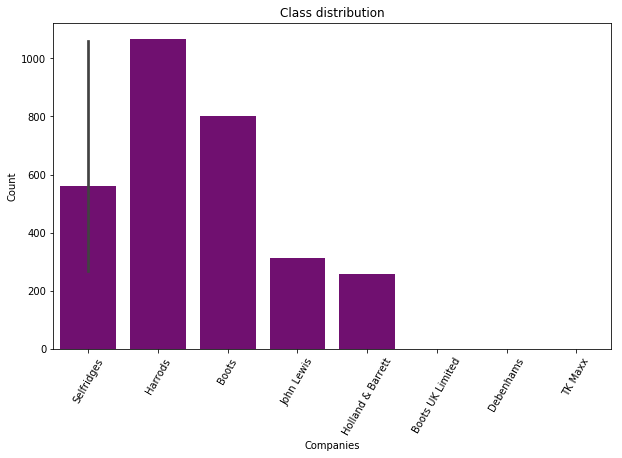

Selfridges           1318
Boots                1068
Harrods              803 
Holland & Barrett    392 
John Lewis           314 
TK Maxx              277 
Debenhams            259 
Boots UK Limited     258 
Name: retailerName, dtype: int64

In [6]:
# class distribution
plt.figure(figsize = (10,6))
_ = sns.barplot(x = df['retailerName'], y = df['retailerName'].value_counts().tolist(), color = 'purple')
_.set(xlabel = 'Companies', ylabel = 'Count', title = 'Class distribution')
plt.xticks(rotation=60)
plt.show()
df['retailerName'].value_counts()

# Data Preprocessing

In [7]:
# checking raw text data
df.rawData.head()

0    {"message":"SUCCESS: Result available","status":"done","status_code":3,"token":null,"success":true,"code":202,"duplicate":false,"duplicateToken":null,"result":{"establishment":"Selfridges","validatedEstablishment":false,"date":"2019-06-14 18:20:00","total":30.000,"url":"www.selfridges.com","phoneNumber":"8569 4004156","paymentMethod":"VISA","address":"400 Oxford Street London W1A 1AB","validatedTotal":false,"subTotal":30.000,"validatedSubTotal":true,"cash":"0.000","change":"0.000","tax":0.000,"discount":0.000,"subTotalConfidence":0.99,"totalConfidence":0.7,"cashConfidence":0.0,"changeConfidence":0.0,"roundingConfidence":0.0,"otherData":[],"lineItems":[{"qty":0,"desc":"FULTON BROLLYMA41568569 400415685692","unit":"","price":0.000,"descClean":"You 193 were served by : Ines FULTON BROLLYMA 400415685692","lineTotal":18.000,"productCode":"41568569"},{"qty":0,"desc":"JJ DOT HYDR - TRA 82401412","unit":"","price":0.000,"descClean":"JJ DOT HYDR - TRA","lineTotal":12.000,"productCode":"824

In [0]:
# removing missing values
df = df.dropna(subset = ['rawData'])

In [0]:
# custom function to get establishment names
def get_name(column):
  """This function returns establishment names from text data
    
    Parameters
    ----------
    column: text data column name 
    
    Returns
    -------
    list:
        establishment names   
    
    """
  l = []
  for row in column: 
    dic = json.loads(row)
    a = dic['result']['establishment']
    l.append(a)
  return l

In [10]:
# creating new 'establishment' column
df['establishment'] = get_name(df['rawData'])

data = df[['establishment', 'retailerName']]
# lowercase all the text
data = data.apply(lambda x: x.astype(str).str.lower())
print(data.establishment.nunique())
data.head(10)


218


,establishment,retailerName
0,selfridges,selfridges
1,harrods,harrods
2,boots,boots
3,selfridges,selfridges
4,john lewis,john lewis
5,selfridges,selfridges
6,holland & barrett,holland & barrett
7,selfridges,selfridges
8,selfridges,selfridges
9,john lewis,john lewis


In [13]:
# checking extracted text data
print(data.establishment.unique())
print(data.shape)

['selfridges' 'harrods' 'boots' 'john lewis' 'holland   barrett'
 'westfield stratford it' 'debenhams' 'holland   baerett' 'tk maxx'
 'osamarine dobio otobewbibwod' 'uk limited' 'innova taxfree uk'
 'nolland   barrett' 'newcastle eldon sq        ' '    the'
 'holland go barrett' 'osamarin' 'holland    barrett' 'gister        trai'
 'holland s barrett' 'wendy' 'bath' 'tiolland   barrett' '      '
 'gilt soon' 'selfridges co' '            ' 'bocts uk limited'
 'selfridges   co' 'blackpool' 'tkmaxx' 'lonu' 'ue du' 'selfridges c '
 'tohn lewis' 'holland   baralit' 'selfridgesc' 'advantage card statement'
 'ww you for shopping at' 'mid  a             ' 'big labels  small pri'
 'ande azamo   a asub sten    ' 'liverpool' 'balis' 'sale' 'dennama'
 'diy iduels  silla preo' 'oder' '           gbp' 'mornado'
 'strand london        ' 'punu bogomebnu se amol ' 'tan loy bao chunan'
 'john lev' '     by  paige' 'shop online at harrods com'
 'tell us how we did' 'boos uk limited' 'tkmax' 'bout uk limi

In [14]:
# text cleaning
import re
def text_preprocess(text):
    # all text to lowercase
    no_apostrophe = text.replace("'", "")
    # remove special characters
    clean_text = re.sub('[^a-zA-Z]', ' ', no_apostrophe)
    return clean_text

  
data['establishment'] = data['establishment'].map(lambda text: text_preprocess(text)) 
data['establishment'].nunique()

210

In [15]:
# replacing 'boots uk limited' with 'boots' 
data['establishment'] = data['establishment'].str.replace('boots uk limited', 'boots')
data['establishment'] = data['establishment'].str.replace('uk limited', 'boots')
data['retailerName'] = data['retailerName'].str.replace('boots uk limited', 'boots')

data.retailerName.unique()


array(['selfridges', 'harrods', 'boots', 'john lewis',
       'holland & barrett', 'debenhams', 'tk maxx'], dtype=object)

## Feature engineering

In [17]:
# generating features from establishment column
threshold = 5 # anything that occurs less than this will be removed.
value_counts = data['establishment'].value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index
data['features'] = data.establishment.replace(to_remove, np.nan)

# removing NaN values
data.dropna(inplace = True)

# checking for null values
print(data.isnull().sum())
print(data.head())
data.shape

establishment    0
retailerName     0
features         0
dtype: int64
  establishment retailerName    features
0  selfridges    selfridges   selfridges
1  harrods       harrods      harrods   
2  boots         boots        boots     
3  selfridges    selfridges   selfridges
4  john lewis    john lewis   john lewis


(4443, 3)

In [18]:
# getting features and outcome variable
X = pd.get_dummies(data['features'])
y = data.retailerName

print(X.shape)
print(y.shape)

(4443, 7)
(4443,)


# Model Building

In [0]:
# a dataset to hold the results for comparison
report = pd.DataFrame()

# define a function 
def run_model(model, params, X_train, y_train, X_test, y_test, i):
    """This function returns best parameters to fit the model and model's accuracy stats
    
    Parameters
    ----------
    model: classifier
    params: parameters
        dictionary
    X_train: the training data set
    y_train: the set of labels to all the data in X_train
    X_test: the test data set
    Y_test: the set of labels to all the data in X_test
    
    Returns
    -------
    str:
        model name
    float:
        Train set accuracy score
    float: 
        Test set accuracy score
    float:
        5 folds cross-validation accuracy score  
    """
    t0 = time()
    # Heading
    print('\n','-'*40,'\n',model.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    search = GridSearchCV(model, params,
                          cv=5).fit(X_train, y_train)
    # Extract best estimator
    best = search.best_estimator_
    print("Best parameters:", search.best_params_)

    # Cross-validate on train set
    cvs = cross_val_score(best, X_train, y_train, cv=5)
    print("Cross-validation stats: mean: {}, std: {}".format(round(cvs.mean(), 4), round(cvs.std(), 5)))
    report.loc[i,'Cross_Val_Mean'] = cvs.mean() 
    report.loc[i,'Cross_Val_Std'] = cvs.std() 
   
    # Get train accuracy
    best = best.fit(X_train,y_train)
    train = best.score(X_train, y_train)
    report.loc[i,'Train_Accuracy'] = train 
    print("\nTrain Accuracy Score:", train)

    # Get test accuracy
    test = best.score(X_test, y_test)
    report.loc[i,'Test_Accuracy'] = test 
    print("\nTest Accuracy Score:", test)
    
    y_pred = best.predict(X_test)

    print(classification_report(y_test, y_pred))

    conf_matrix = pd.crosstab(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    report.loc[i,'n_train'] = len(X_train)
    report.loc[i,'Model'] = model.__class__.__name__
    print(time()-t0,'seconds.')

In [22]:
# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=42, stratify = y)
                        
print(X_train.shape)
print(X_test.shape)


(3998, 7)
(445, 7)


## Train and Test data

## Logistic Regression (Ridge technique)


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: {'C': 0.3, 'penalty': 'l2', 'solver': 'newton-cg'}
Cross-validation stats: mean: 0.999, std: 0.00146

Train Accuracy Score: 0.9989994997498749

Test Accuracy Score: 0.9977528089887641
                   precision    recall  f1-score   support

            boots       0.99      1.00      1.00       128
        debenhams       1.00      1.00      1.00        20
          harrods       1.00      1.00      1.00        79
holland & barrett       1.00      0.97      0.99        35
       john lewis       1.00      1.00      1.00        30
       selfridges       1.00      1.00      1.00       130
          tk maxx       1.00      1.00      1.00        23

         accuracy                           1.00       445
        macro avg       1.00      1.00      1.00       445
     weighted avg       1.00      1.00      1.00       445



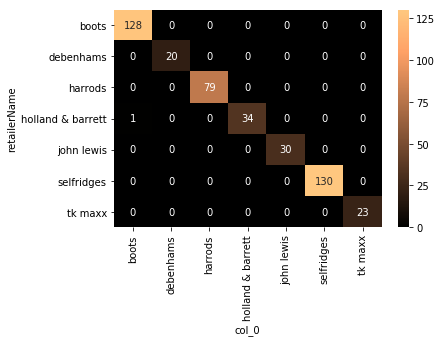

19.12214183807373 seconds.


In [23]:
params = [{
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l2']
    },{
    'solver': ['liblinear','saga'],
    'C': [0.3, 0.5, 0.7, 1],
    'penalty': ['l1','l2']
}]

lr = LogisticRegression(
    n_jobs=-1 # Use all CPU
)

run_model(lr, params, X_train, y_train, X_test, y_test, i=1)

## Random Forest Classifier


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'entropy'}
Cross-validation stats: mean: 0.999, std: 0.00146

Train Accuracy Score: 0.9989994997498749

Test Accuracy Score: 0.9977528089887641
                   precision    recall  f1-score   support

            boots       0.99      1.00      1.00       128
        debenhams       1.00      1.00      1.00        20
          harrods       1.00      1.00      1.00        79
holland & barrett       1.00      0.97      0.99        35
       john lewis       1.00      1.00      1.00        30
       selfridges       1.00      1.00      1.00       130
          tk maxx       1.00      1.00      1.00        23

         accuracy                           1.00       445
        macro avg       1.00      1.00      1.00       445
     weighted avg       1.00      1.00      1.00       445



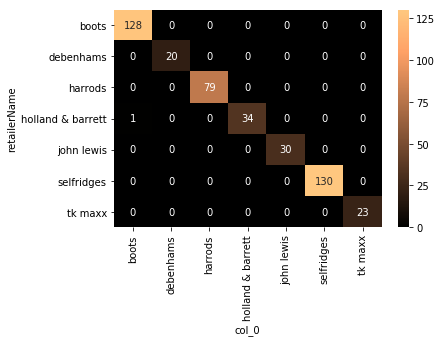

1.1111981868743896 seconds.


In [24]:
params = {
    'criterion':['entropy','gini'],
}

# initialize the classifier
rfc = RandomForestClassifier()

run_model(rfc, params, X_train, y_train, X_test, y_test,i=2)

## XGBoost Classifier


 ---------------------------------------- 
 XGBClassifier 
 ----------------------------------------
Best parameters: {'learning_rate': 0.001, 'max_depth': 3}
Cross-validation stats: mean: 0.999, std: 0.00146

Train Accuracy Score: 0.9989994997498749

Test Accuracy Score: 0.9977528089887641
                   precision    recall  f1-score   support

            boots       0.99      1.00      1.00       128
        debenhams       1.00      1.00      1.00        20
          harrods       1.00      1.00      1.00        79
holland & barrett       1.00      0.97      0.99        35
       john lewis       1.00      1.00      1.00        30
       selfridges       1.00      1.00      1.00       130
          tk maxx       1.00      1.00      1.00        23

         accuracy                           1.00       445
        macro avg       1.00      1.00      1.00       445
     weighted avg       1.00      1.00      1.00       445



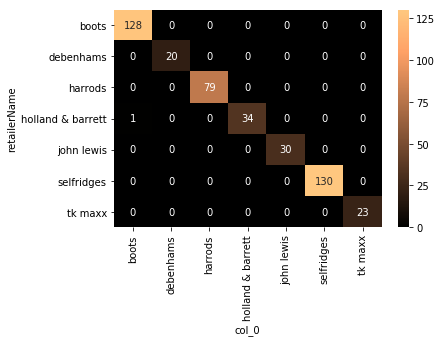

19.698041439056396 seconds.


In [25]:
max_depth = [3, 5]
learning_rate = [0.001, 0.01, 0.1]

params = dict(max_depth = max_depth, 
              learning_rate = learning_rate)

# initialize the classifier
xgb = xgb.XGBClassifier()

run_model(xgb, params, X_train, y_train, X_test, y_test,i=3)

## Support Vector Classifier


 ---------------------------------------- 
 SVC 
 ----------------------------------------
Best parameters: {'C': 0.1}
Cross-validation stats: mean: 0.999, std: 0.00146

Train Accuracy Score: 0.9989994997498749

Test Accuracy Score: 0.9977528089887641
                   precision    recall  f1-score   support

            boots       0.99      1.00      1.00       128
        debenhams       1.00      1.00      1.00        20
          harrods       1.00      1.00      1.00        79
holland & barrett       1.00      0.97      0.99        35
       john lewis       1.00      1.00      1.00        30
       selfridges       1.00      1.00      1.00       130
          tk maxx       1.00      1.00      1.00        23

         accuracy                           1.00       445
        macro avg       1.00      1.00      1.00       445
     weighted avg       1.00      1.00      1.00       445



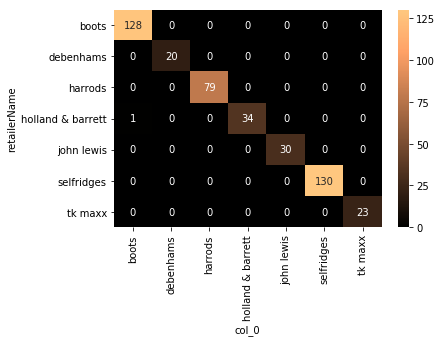

3.5592544078826904 seconds.


In [26]:
Cs = [0.01, 0.1, 1]

params = dict(C=Cs)

# initialize and run the model
svc = SVC(kernel = 'rbf')
run_model(svc, params, X_train, y_train, X_test, y_test, i=5)

# Model Selection

In [27]:
report

,Cross_Val_Mean,Cross_Val_Std,Train_Accuracy,Test_Accuracy,n_train,Model
1,0.998998,0.001461,0.998999,0.997753,3998.0,LogisticRegression
2,0.998998,0.001461,0.998999,0.997753,3998.0,RandomForestClassifier
3,0.998998,0.001461,0.998999,0.997753,3998.0,XGBClassifier
5,0.998998,0.001461,0.998999,0.997753,3998.0,SVC


# Hyperparameter Tuning for Random Forest Classifier 

In [0]:
params = {'criterion':['entropy','gini'],
 'max_depth': [10, 20, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5],
 'n_estimators': [200, 500]}


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Cross-validation stats: mean: 0.999, std: 0.00146

Train Accuracy Score: 0.9989994997498749

Test Accuracy Score: 0.9977528089887641
                   precision    recall  f1-score   support

            boots       0.99      1.00      1.00       128
        debenhams       1.00      1.00      1.00        20
          harrods       1.00      1.00      1.00        79
holland & barrett       1.00      0.97      0.99        35
       john lewis       1.00      1.00      1.00        30
       selfridges       1.00      1.00      1.00       130
          tk maxx       1.00      1.00      1.00        23

         accuracy                           1.00       445
        macro avg       1.00      1.00      1.00       445
     weighted

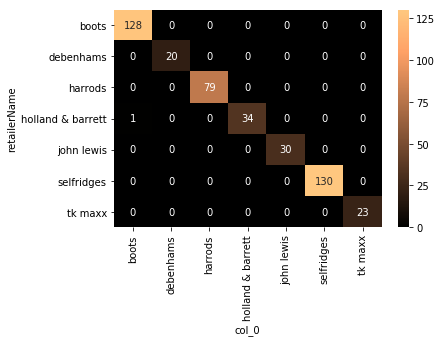

526.7216432094574 seconds.


In [29]:
rfc = RandomForestClassifier()
run_model(rfc, params, X_train, y_train, X_test, y_test, 6)

# Extract Model

In [30]:
from sklearn.externals import joblib

# initializing classifier
clf = RandomForestClassifier(criterion = 'entropy',
                            max_features = 'auto',
                            n_estimators = 200)

clf.fit(X_train, y_train)

# score model
clf.score(X_test, y_test)

0.9977528089887641

In [31]:
joblib.dump(clf, 'ocr_classifier.pkl')

['ocr_classifier.pkl']

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip freeze --local > /content/gdrive/My\ Drive/colab_installed.txt


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!jupyter nbconvert OCR_Classifier.ipynb --to html --output OCR_Classifier.html

[NbConvertApp] Converting notebook OCR_Classifier.ipynb to html
[NbConvertApp] Writing 515355 bytes to OCR_Classifier.html
